## A little history of Convolutional Neural Networks

### Content
- Intro
- CNNs
- Dataset
- Different CNN architectures
- Excercises  

#### CNNs
In this tutorial we will be looking at CNNs. Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous week: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. SVM/Softmax) on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

So what changes? CNN architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

How do they make it more efficient? With convolutional layers.
A convolution is the simple application of a filter to an input that results in an activation. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image.

The innovation of convolutional neural networks is the ability to automatically learn a large number of filters in parallel specific to a training dataset under the constraints of a specific predictive modeling problem, such as image classification. The result is highly specific features that can be detected anywhere on input images.

In [116]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import math

#from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import experimental
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, AveragePooling2D, Lambda, Activation

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import numpy as np
from keras.utils import to_categorical
from keras.utils import plot_model


%matplotlib inline

In [61]:
!pip install -q tfds-nightly tensorflow matplotlib

TFDS provides a collection of ready-to-use datasets for use with TensorFlow, Jax, and other Machine Learning frameworks. More info here: https://www.tensorflow.org/datasets/overview

It handles downloading and preparing the data deterministically and constructing a tf.data.Dataset (or np.array).

As always, if you haven't installed it yet run ```!pip install tensorflow-datasets```.

In [78]:
# Construct a tf.data.Dataset
ds, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = ds['train'], ds['test']

In [80]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [66]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/home/bm/tensorflow_datasets/fashion_mnist/3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasu

In [71]:
ds = tfds.load('fashion_mnist', split='train', as_supervised=True)
ds = ds.take(1)  # Only take a single example

for image, label in ds:  # example is (image, label)
  print(image.shape, label)

(28, 28, 1) tf.Tensor(2, shape=(), dtype=int64)


#### Verify the data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

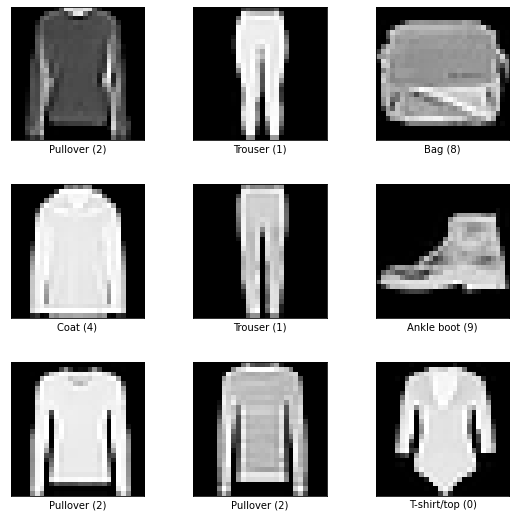

In [72]:
ds, info = tfds.load('fashion_mnist', split='train', with_info=True)

fig = tfds.show_examples(ds, info)

In [81]:
# Data normalization
#We then normalize the data dimensions so that they are of approximately the same scale.

def normalize(images, labels):
   images = tf.cast(images, tf.float32)
   images /= 255
   return images, labels
# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)
# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [82]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [85]:
# MNIST data input (img shape: 28*28)
n_input = (28,28,1)

# MNIST total classes (0-9 digits)
n_classes = 10

   LeNet-5 is a type of CNN architecture designed for hand-written and machine-printed character recognition. It is   from the paper Gradient-Based Learning Applied to Document Recognition , Paper: Gradient-Based Learning Applied to Document Recognition  , published  by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner  in 1998( Proceedings of the IEEE). This architecture is simple and also considered as basic of CNN.                                                           It has total seven layer , contains ,two sets of convolutional and average pooling layers,  followed by a flattening convolutional layer, then two fully-connected layers and finally a SoftMax classifier.  In each layer there are multiple neurons.

In [86]:
# LeNet-5 model
class LeNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding="same"))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='tanh'))
        self.add(Dense(84, activation='tanh'))
        self.add(Dense(nb_classes, activation='softmax')) #softmax

        self.compile(optimizer='adam',
                    loss='SparseCategoricalCrossentropy',
                    metrics=['accuracy'])

The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Note that while ReLUs and max-pooling work better, these discoveries had not yet been made in the 1990s. Each convolutional layer uses a 5×5
kernel and a sigmoid activation function. These layers map spatially arranged inputs to a number of two-dimensional feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while the second has 16. Each 2×2 pooling operation (stride 2) reduces dimensionality by a factor of 4
via spatial downsampling. The convolutional block emits an output with shape given by (batch size, number of channel, height, width).

In order to pass output from the convolutional block to the dense block, we must flatten each example in the minibatch. In other words, we take this four-dimensional input and transform it into the two-dimensional input expected by fully-connected layers: as a reminder, the two-dimensional representation that we desire has uses the first dimension to index examples in the minibatch and the second to give the flat vector representation of each example. LeNet’s dense block has three fully-connected layers, with 120, 84, and 10 outputs, respectively. Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.

Here, we need to compile the model to train. Before compiling, it is required to define loss function and optimizer. As you can see in the documentation, there are lots of loss functions predefined. In this task, we need to classify the label, so our loss function may be categorical crossentropy. But keep in mind that, if your labelis one-hot encoded, you need to use categorical_crossentropy. If it is just an integer, meaning its label index, our loss function may be SparseCategoricalCrossentropy.

And mainly-used optimizer is Adam with 0.01 learning rate.

In [87]:
lenet = LeNet((28,28,1), 10)

In [90]:
#Train the model
lenet.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.6654 - accuracy: 0.7570
Epoch 2/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.3715 - accuracy: 0.8645
Epoch 3/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.3377 - accuracy: 0.8766
Epoch 4/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2886 - accuracy: 0.8930
Epoch 5/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.2692 - accuracy: 0.9006


In [107]:
lenet.save('lenet_mnist_fashion')

INFO:tensorflow:Assets written to: lenet_mnist_fashion/assets


INFO:tensorflow:Assets written to: lenet_mnist_fashion/assets


In [91]:
#Evaluate the accuracy
test_loss, test_accuracy = lenet.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 5s 14ms/step - loss: 0.3307 - accuracy: 0.8780
Accuracy on test dataset: 0.878000020980835


In [97]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = lenet.predict(test_images)


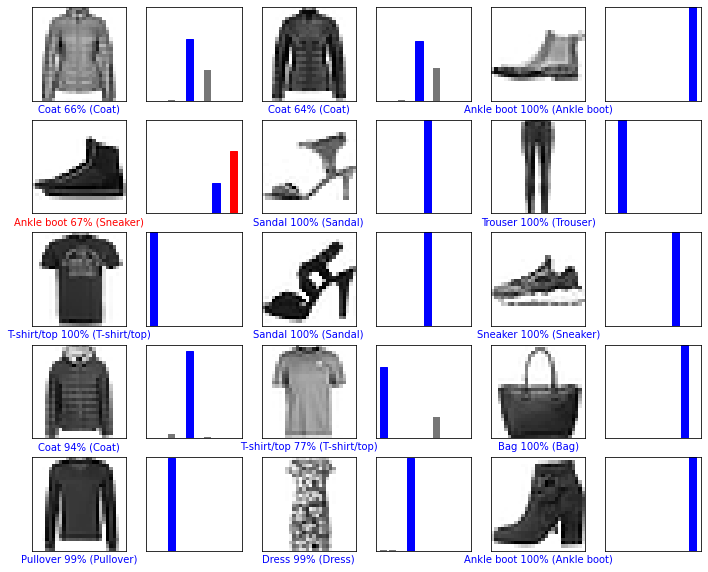

In [98]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

### Exercises

a. Replace the average pooling with max pooling. What happens?

b. Try to construct a more complex network based on LeNet to improve its accuracy.
    - Adjust the convolution window size.
    - Adjust the number of output channels.
    - Adjust the activation function (e.g., ReLU).
    - Adjust the number of convolution layers.
    - Adjust the number of fully connected layers.
    - Adjust the learning rates and other training details (e.g., initialization and number of epochs.)


In [99]:
# modified LeNet-5 model
class CNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding="same"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='tanh'))
        self.add(Dense(84, activation='tanh'))
        self.add(Dense(nb_classes, activation='softmax'))

        self.compile(optimizer='adam',
                    loss='SparseCategoricalCrossentropy',
                    metrics=['accuracy'])

In [100]:
Cnet = CNet((28,28,1), 10)

#Train the model
Cnet.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.6157 - accuracy: 0.7745
Epoch 2/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.3304 - accuracy: 0.8806
Epoch 3/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.2760 - accuracy: 0.8978
Epoch 4/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2580 - accuracy: 0.9049
Epoch 5/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2264 - accuracy: 0.9170


In [106]:
Cnet.save('cnet_mnist_fashion')

INFO:tensorflow:Assets written to: cnet_mnist_fashion/assets


INFO:tensorflow:Assets written to: cnet_mnist_fashion/assets


In [101]:
#Evaluate the accuracy
test_loss, test_accuracy = Cnet.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 11ms/step - loss: 0.2792 - accuracy: 0.8983
Accuracy on test dataset: 0.8982999920845032


In [102]:
# premium LeNet-5 model
class CNNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()

        self.add(Conv2D(12, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(24, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(84, activation='relu'))
        self.add(Dense(nb_classes, activation='softmax'))

        self.compile(optimizer='adam',
                    loss='SparseCategoricalCrossentropy',
                    metrics=['accuracy'])

In [103]:
Cnnet = CNNet((28,28,1), 10)

#Train the model
Cnnet.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.6569 - accuracy: 0.7604
Epoch 2/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3314 - accuracy: 0.8814
Epoch 3/5
1875/1875 [==============================] - 47s 25ms/step - loss: 0.2807 - accuracy: 0.8991
Epoch 4/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2468 - accuracy: 0.9100
Epoch 5/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2248 - accuracy: 0.9179


In [108]:
Cnnet.save('Cnnet_mnist_fashion')

INFO:tensorflow:Assets written to: Cnnet_mnist_fashion/assets


INFO:tensorflow:Assets written to: Cnnet_mnist_fashion/assets


In [105]:
#Evaluate the accuracy
test_loss, test_accuracy = Cnnet.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.2771 - accuracy: 0.8988
Accuracy on test dataset: 0.8988000154495239


### AlexNet

The one that started it all (Though some may say that Yann LeCun’s paper in 1998 was the real pioneering publication). This paper, titled “ImageNet Classification with Deep Convolutional Networks”, has been cited a total of 6,184 times and is widely regarded as one of the most influential publications in the field. Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton created a “large, deep convolutional neural network” that was used to win the 2012 ILSVRC (ImageNet Large-Scale Visual Recognition Challenge). For those that aren’t familiar, this competition can be thought of as the annual Olympics of computer vision, where teams from across the world compete to see who has the best computer vision model for tasks such as classification, localization, detection, and more. 2012 marked the first year where a CNN was used to achieve a top 5 test error rate of 15.4% (Top 5 error is the rate at which, given an image, the model does not output the correct label with its top 5 predictions). The next best entry achieved an error of 26.2%, which was an astounding improvement that pretty much shocked the computer vision community. Safe to say, CNNs became household names in the competition from then on out.

In the paper, the group discussed the architecture of the network (which was called AlexNet). They used a relatively simple layout, compared to modern architectures. The network was made up of 5 conv layers, max-pooling layers, dropout layers, and 3 fully connected layers. The network they designed was used for classification with 1000 possible categories.

##### Why It’s Important

The neural network developed by Krizhevsky, Sutskever, and Hinton in 2012 was the coming out party for CNNs in the computer vision community. This was the first time a model performed so well on a historically difficult ImageNet dataset. Utilizing techniques that are still used today, such as data augmentation and dropout, this paper really illustrated the benefits of CNNs and backed them up with record breaking performance in the competition.

In [117]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape))
        # Here, we use a larger 11 x 11 window to capture objects. At the same time,
        # we use a stride of 4 to greatly reduce the height and width of the output.
        # Here, the number of output channels is much larger than that in LeNet
        self.add(Conv2D(96, 11, strides=4, padding='same'))
        self.add(Lambda(tf.nn.local_response_normalization))
        self.add(Activation('relu'))
        self.add(MaxPooling2D(3, strides=2))
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        self.add(Conv2D(256, 5, strides=4, padding='same'))
        self.add(Lambda(tf.nn.local_response_normalization))
        self.add(Activation('relu'))
        self.add(MaxPooling2D(3, strides=2))
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        self.add(Conv2D(384, 3, strides=4, padding='same'))
        self.add(Activation('relu'))
        self.add(Conv2D(384, 3, strides=4, padding='same'))
        self.add(Activation('relu'))
        self.add(Conv2D(256, 3, strides=4, padding='same'))
        self.add(Activation('relu'))
        self.add(Flatten())
        # Here, the number of outputs of the fully connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(0.5))
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        self.add(Dense(num_classes, activation='softmax'))
        
        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
            loss='SparseCategoricalCrossentropy',
            metrics=['accuracy'])

In [118]:
Alexnet = AlexNet((28,28,1), 10)

In [119]:
#Train the model
###takes some time 1 epoch --> 20 min

Alexnet.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 1656s 883ms/step - loss: 0.9253 - accuracy: 0.6207
Epoch 2/5
1875/1875 [==============================] - 1356s 723ms/step - loss: 0.3688 - accuracy: 0.8683
Epoch 3/5
1875/1875 [==============================] - 1464s 781ms/step - loss: 0.3115 - accuracy: 0.8901
Epoch 4/5
1875/1875 [==============================] - 1200s 640ms/step - loss: 0.2755 - accuracy: 0.9033
Epoch 5/5
1875/1875 [==============================] - 1191s 635ms/step - loss: 0.2465 - accuracy: 0.9117


In [120]:
Alexnet.save('alexnet_fashion_mnist')

INFO:tensorflow:Assets written to: alexnet_fashion_mnist/assets


INFO:tensorflow:Assets written to: alexnet_fashion_mnist/assets


In [121]:
#Evaluate the accuracy
test_loss, test_accuracy = Alexnet.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 41s 131ms/step - loss: 0.2950 - accuracy: 0.8907
Accuracy on test dataset: 0.8906999826431274


In [202]:
###takes some time 1 epoch --> 20 min
Alexnet.save('Alexnet_trained')

INFO:tensorflow:Assets written to: Alexnet_trained/assets


#### Other famous CNN architectures 

- ZF Net (2013)
- VGG (2014)
- GoogLeNet (2015)
- Microsoft ResNet (2015)

Most of these models can be loaded from tensorflow and can be downloaded with pre-trained weights. More here:
https://www.tensorflow.org/api_docs/python/tf/keras/applications